In [1]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python-headless


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imgaug


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB2
from sklearn.model_selection import train_test_split, KFold
from keras import backend as K
from tensorflow.keras.metrics import Metric

# Fix R2 metric for TensorFlow 2.x
class R2(Metric):
    def __init__(self, name="r2", **kwargs):
        super(R2, self).__init__(name=name, **kwargs)
        self.sse = self.add_weight(name="sse", initializer="zeros", dtype=tf.float32)
        self.sst = self.add_weight(name="sst", initializer="zeros", dtype=tf.float32)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        error = y_true - y_pred
        self.sse.assign_add(tf.reduce_sum(tf.square(error)))
        self.sst.assign_add(tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))))

    def result(self):
        return 1 - self.sse / (self.sst + K.epsilon())

    def reset_states(self):
        self.sse.assign(0.0)
        self.sst.assign(0.0)

# Load train dataset
train_df = pd.read_csv('/kaggle/input/machine-learning-in-science-ii-2023/training_norm.csv') 

# Load training images
train_images = []
for image_id in train_df['image_id']:
    image = cv2.imread(f'/kaggle/input/machine-learning-in-science-ii-2023/training_data/training_data/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_images.append(image)
train_images = np.array(train_images)

# Extract labels
train_angles = np.array(train_df['angle'])
train_speeds = np.array(train_df['speed'])

# Load test dataset
test_images = []
for i in range(1, 1021):
    image = cv2.imread(f'/kaggle/input/machine-learning-in-science-ii-2023/test_data/test_data/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
test_images = np.array(test_images)

# Split train & validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_df[['angle', 'speed']].values, test_size=0.2, random_state=42
)

# Build the model with EfficientNetB2
def build_model():
    base_model = EfficientNetB2(include_top=False, input_shape=(240, 320, 3), weights='imagenet')

    # Freeze base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layers
    angle_output = Dense(1, name='angle_output')(x)
    speed_output = Dense(1, name='speed_output')(x)
    model = Model(inputs=base_model.input, outputs=[angle_output, speed_output])

    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    loss = {'angle_output': 'mean_squared_error', 'speed_output': 'mean_squared_error'}
    metrics = {
        'angle_output': ['mae', 'mse', R2(name='angle_r2')], 
        'speed_output': ['mae', 'mse', R2(name='speed_r2')]
    }
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Perform K-Fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold_number, (train_index, val_index) in enumerate(kfold.split(train_images, train_df[['angle', 'speed']].values), 1):
    print(f'Fold {fold_number}/{num_folds}')

    # Split training & validation data for the fold
    X_train_fold, X_val_fold = train_images[train_index], train_images[val_index]
    y_train_fold, y_val_fold = train_df[['angle', 'speed']].values[train_index], train_df[['angle', 'speed']].values[val_index]

    # Train model
    model = build_model()
    history = model.fit(
        X_train_fold, 
        {'angle_output': y_train_fold[:, 0], 'speed_output': y_train_fold[:, 1]},
        epochs=100, 
        batch_size=16, 
        verbose=1,
        validation_data=(X_val_fold, {'angle_output': y_val_fold[:, 0], 'speed_output': y_val_fold[:, 1]}),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
    )

# Final Training on Full Dataset
model = build_model()
history = model.fit(
    X_train, 
    {'angle_output': y_train[:, 0], 'speed_output': y_train[:, 1]},
    epochs=100, 
    batch_size=256, 
    verbose=1,
    validation_data=(X_val, {'angle_output': y_val[:, 0], 'speed_output': y_val[:, 1]}),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
)

Fold 1/5
Epoch 1/100
690/690 ━━━━━━━━━━━━━━━━━━━━ 88s 91ms/step - angle_output_angle_r2: -804.5046 - angle_output_loss: 1.1757 - angle_output_mae: 0.7259 - angle_output_mse: 1.1757 - loss: 2.5138 - speed_output_loss: 1.3381 - speed_output_mae: 0.8076 - speed_output_mse: 1.3381 - speed_output_speed_r2: -131.7601 - val_angle_output_angle_r2: -74.2936 - val_angle_output_loss: 0.1077 - val_angle_output_mae: 0.2861 - val_angle_output_mse: 0.1078 - val_loss: 0.3942 - val_speed_output_loss: 0.2866 - val_speed_output_mae: 0.5104 - val_speed_output_mse: 0.2864 - val_speed_output_speed_r2: -27.8324
Epoch 2/100
690/690 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - angle_output_angle_r2: -256.7848 - angle_output_loss: 0.3640 - angle_output_mae: 0.2713 - angle_output_mse: 0.3640 - loss: 0.8158 - speed_output_loss: 0.4518 - speed_output_mae: 0.5166 - speed_output_mse: 0.4518 - speed_output_speed_r2: -41.4534 - val_angle_output_angle_r2: -32.8532 - val_angle_output_loss: 0.0488 - val_angle_output_mae: 0.1495 

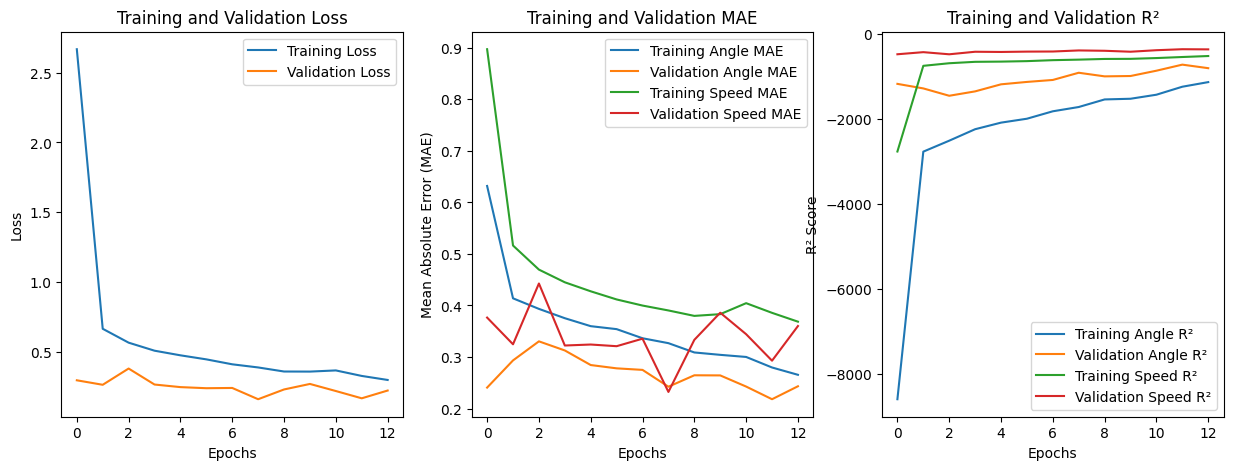

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # 適當調整圖表大小

    # Plot Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot MAE
    ax2.plot(history.history['angle_output_mae'], label='Training Angle MAE')
    ax2.plot(history.history['val_angle_output_mae'], label='Validation Angle MAE')
    ax2.plot(history.history['speed_output_mae'], label='Training Speed MAE')
    ax2.plot(history.history['val_speed_output_mae'], label='Validation Speed MAE')
    ax2.set_title('Training and Validation MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Error (MAE)')
    ax2.legend()

    # Plot R-squared
    ax3.plot(history.history['angle_output_angle_r2'], label='Training Angle R²')
    ax3.plot(history.history['val_angle_output_angle_r2'], label='Validation Angle R²')
    ax3.plot(history.history['speed_output_speed_r2'], label='Training Speed R²')
    ax3.plot(history.history['val_speed_output_speed_r2'], label='Validation Speed R²')
    ax3.set_title('Training and Validation R²')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R² Score')
    ax3.legend()

    plt.show()

# 執行繪圖
plot_learning_curves(history)

In [19]:
# Make predictions on the test set
test_predictions = model.predict(test_images)

# Get the steering angle and speed predictions separately
test_steering_predictions = test_predictions[0]    
test_speed_predictions = test_predictions[1]

# Save the submission dataframe as a CSV file
submission_df.to_csv('submission effnet with imguag and K-fold.csv', index=False)